<a href="https://colab.research.google.com/github/amit5-ai/bert_fine_tune_pytorch/blob/main/pytorch_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine-tune a pretrained model with Transformers Trainer.

# packages import and install

In [ ]:
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install accelerate
!pip install nltk
!pip install modelsummary

  Preparing metadata (setup.py) ... done
  Created wheel for modelsummary: filename=modelsummary-1.1.7-py3-none-any.whl size=6939 sha256=622314d1423e7727bfb1dd0f8a14d967412343820facb7ae32ff00538abb76bc
  Stored in directory: /root/.cache/pip/wheels/22/25/f8/c50d3e8817c926910f8eb760f8ca4e10a854b36218e7553be9
Successfully built modelsummary


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer,AutoModelForSequenceClassification,TrainingArguments,Trainer
import numpy as np
import evaluate
import accelerate
import string
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from modelsummary import summary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dataset = load_dataset("lex_glue",'ledgar')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset["train"][0]

{'text': 'Except as otherwise set forth in this Debenture, the Company, for itself and its legal representatives, successors and assigns, expressly waives presentment, protest, demand, notice of dishonor, notice of nonpayment, notice of maturity, notice of protest, presentment for the purpose of accelerating maturity, and diligence in collection.',
 'label': 97}

# data pre-prcoessing

In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [ ]:
def preprocess_function(examples):
    examples["text"] = [remove_stopwords(remove_punctuation(x)) for x in examples["text"]]
    return examples

In [ ]:
train = dataset['train'].map(preprocess_function, batched=True)
test = dataset['test'].map(preprocess_function, batched=True)
validation = dataset['validation'].map(preprocess_function, batched=True)

Use tokenizer to process the text and include a padding and truncation strategy to handle any variable sequence lengths.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

To process dataset in one step, use Datasets map() to apply a preprocessing function over the entire dataset

In [ ]:
tokenized_train = dataset['train'].map(tokenize_function, batched=True)
tokenized_test = dataset['test'].map(tokenize_function, batched=True)
tokenized_validation = dataset['validation'].map(tokenize_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

 create a smaller subset of the full dataset to fine-tune on to reduce the time it takes

In [ ]:
small_train_dataset = tokenized_train.shuffle(seed=42).select(range(5000))
small_eval_dataset = tokenized_validation.shuffle(seed=42).select(range(5000))

# pretrained BERT model and tokenizer

You will see a warning about some of the pretrained weights not being used and some weights being randomly initialized. Don’t worry, this is completely normal! The pretrained head of the BERT model is discarded, and replaced with a randomly initialized classification head. You will fine-tune this new model head on your sequence classification task, transferring the knowledge of the pretrained model to it.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased",
                                                           num_labels=100 )                 # 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer does not automatically evaluate model performance during training. You’ll need to pass Trainer a function to compute and report metrics. The Evaluate library provides a simple accuracy function you can load with the evaluate.load()

Call compute on metric to calculate the accuracy of your predictions. Before passing your predictions to compute, you need to convert the logits to predictions (remember all Transformers models return logits):

In [ ]:
def compute_metrics(eval_pred):
    metric1 = evaluate.load("precision")
    metric2 = evaluate.load("recall")
    metric3 = evaluate.load("f1")
    metric4 = evaluate.load("accuracy")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision = metric1.compute(predictions=predictions, references=labels,
                                average="micro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels,
                             average="micro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels,
                         average="micro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)[
        "accuracy"]

    return {"precision": precision, "recall": recall, "f1": f1,
            "accuracy": accuracy}

# training

Start TensorBoard before training to monitor it in progress

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir 'test_trainer'/runs

In [ ]:
# %reload_ext tensorboard

Create a TrainingArguments class which contains all the hyperparameters you can tune as well as flags for activating different training options. For this tutorial you can start with the default training hyperparameters, but feel free to experiment with these to find your optimal settings.

To monitor your evaluation metrics during fine-tuning, specify the evaluation_strategy parameter in your training arguments to report the evaluation metric at the end of each epoch:

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer",
                                  # evaluation_strategy="epoch",
                                  evaluation_strategy="steps",
                                  eval_steps=7500,                 # number_train/batch_size
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  num_train_epochs=3,
                                  # report_to="tensorboard"
                                  )

Transformers provides a Trainer class optimized for training Transformers models, making it easier to start training without manually writing your own training loop. The Trainer API supports a wide range of training options and features such as logging, gradient accumulation, and mixed precision.

Create a Trainer object with your model, training arguments, training and test datasets, and evaluation function

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    # train_dataset=small_train_dataset,
    # eval_dataset=small_eval_dataset,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    compute_metrics=compute_metrics,        #  The function that will be used to compute metrics at evaluation.
    tokenizer=tokenizer,
)

Then fine-tune your model by calling train()

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
7500,0.739600,0.667998,0.822300,0.822300,0.822300,0.822300
15000,0.493900,0.586382,0.851500,0.851500,0.851500,0.851500
22500,0.320900,0.571167,0.866900,0.866900,0.866900,0.866900


TrainOutput(global_step=22500, training_loss=0.652386006673177, metrics={'train_runtime': 4801.2153, 'train_samples_per_second': 37.491, 'train_steps_per_second': 4.686, 'total_flos': 4.740166213632e+16, 'train_loss': 0.652386006673177, 'epoch': 3.0})

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
for layer_name, params in model.named_parameters():
    print(layer_name, params.shape)

bert.embeddings.word_embeddings.weight torch.Size([28996, 768])
bert.embeddings.position_embeddings.weight torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert.embeddings.LayerNorm.weight torch.Size([768])
bert.embeddings.LayerNorm.bias torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
bert.encoder

In [ ]:
def predict_class(lst):
  return [np.argmax(pred) for pred in lst]

In [ ]:
y_pred = trainer.predict(tokenized_test)

In [ ]:
pred_lbl = predict_class(y_pred[0])

# fine-tuned model perf. eval on test data

In [ ]:
print(classification_report(tokenized_test['label'], pred_lbl))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        88
           1       0.68      0.48      0.56        48
           2       0.82      0.90      0.86       224
           3       0.95      0.91      0.93        23
           4       1.00      0.04      0.07        53
           5       0.62      0.62      0.62        26
           6       0.83      0.96      0.89        47
           7       0.87      0.90      0.88       195
           8       0.00      0.00      0.00         4
           9       0.60      0.56      0.58        62
          10       0.74      0.79      0.76        90
          11       0.97      0.97      0.97       112
          12       0.83      0.74      0.78        81
          13       0.68      0.81      0.74       126
          14       1.00      1.00      1.00         2
          15       0.97      0.99      0.98        70
          16       0.97      0.95      0.96        63
          17       0.94    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-26-321d8af890b4>:2: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


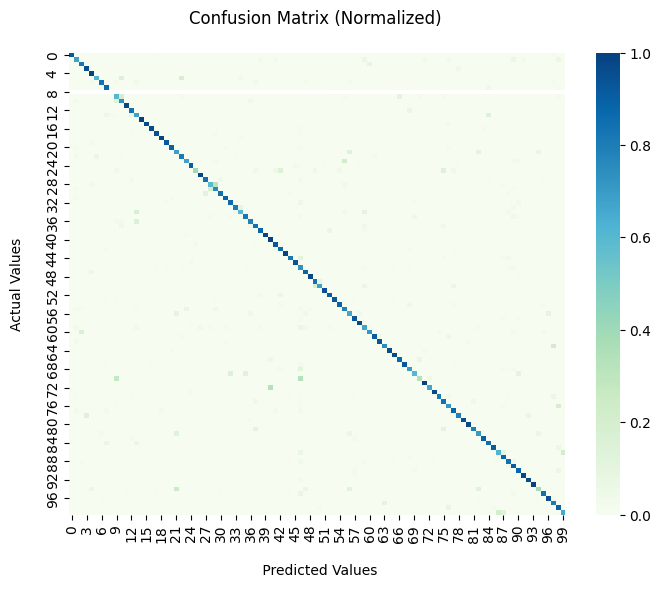

In [ ]:
cm = confusion_matrix(pred_lbl,tokenized_test['label'])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
fx = sns.heatmap(cmn, fmt='.2f', cmap= 'GnBu') # cmap="GnBu"
fx.set_title('Confusion Matrix (Normalized) \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

# push fine-tuned model to huggingface

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
trainer.push_to_hub("AmitTewari/LegalPro-BERT")

events.out.tfevents.1715836622.58394d5d4d26.4795.1:   0%|          | 0.00/9.16k [00:00<?, ?B/s]

events.out.tfevents.1715837015.58394d5d4d26.19926.0:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/434M [00:00<?, ?B/s]

events.out.tfevents.1715835138.58394d5d4d26.4795.0:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/AmitTewari/test_trainer/commit/3fadda4002fc230b2195e1fe4c499af158418838', commit_message='AmitTewari/LegalPro-BERT', commit_description='', oid='3fadda4002fc230b2195e1fe4c499af158418838', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# # Runtime termination code
# from google.colab import runtime
# runtime.unassign()

To test inference API - https://huggingface.co/AmitTewari/test_trainer

In [ ]:
print(tokenized_test[0]['label'])
print(tokenized_test[0]['text'])
print(pred_lbl[0])

35
Executive agrees to be employed with the Company, and the Company agrees to employ Executive, during the Term and on the terms and conditions set forth in this Agreement. Executive agrees during the term of this Agreement to devote substantially all of Executive’s business time, efforts, skills and abilities to the performance of Executive’s duties to the Company and to the furtherance of the Company's business.
35


Fine-tune a pretrained model - https://huggingface.co/docs/transformers/en/training